In [1]:
# for installing java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# for downloading hadoop for spark
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzipping hadoop for spark
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# setting environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# installing spark on the current environment
!pip install -q findspark
import findspark
findspark.init()

# mount your google drive to be able to access files from your google drive ! 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pyspark

sc = pyspark.SparkContext(appName="Working with Key Value RDD Solutions")

#Part 1 : Donald Trump Communication Analysis on Twitter


You are big data analyst for a communication agency who wants to analyze
Donald Trump’s communication on Twitter.
You have an history of Donald trump tweets: more than 58 000 tweets from 2009
to November 19th, 2020 in the form of a text file - trump_tweets.txt
You are tasked to explore this dataset by using Spark, because your analysis
should also be able to apply on very large data sets, for instance to analyze the
communication on social media of other public figures.
Each line of this text file is in the form: text_of_the_tweet;date_of_the_tweet
Each tweet can be an original tweet or a retweet, each retweet starts with the
keyword ‘RT’
You should present your keys findings in form of lists, tables, or visualizations.
You can have bonus points by providing more visual results (e.g., charts, word
clouds) by using python libraries such as seaborn (or others).

In [3]:
tweets = sc.textFile('drive/MyDrive/Spark_Project/DATA/trump_tweets.txt')

In [4]:
tweets.take(100)

['Republicans and Democrats have both created our economic problems.;02/08/2011 18:07:48',
 'I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y;03/03/2020 01:34:50',
 'RT @CBS_Herridge: READ: Letter to surveillance court obtained by CBS News questions where there will be further disciplinary action and cho…;17/01/2020 03:22:47',
 'The Unsolicited Mail In Ballot Scam is a major threat to our Democracy, &amp  the Democrats know it. Almost all recent elections using this system, even though much smaller &amp   with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots &amp  Fraud!;12/09/2020 20:10:58',
 "RT @MZHemingway: Very friendly telling of events here about Comey's apparent leaking to compliant media. If you read those 

## 1. Search for top positives and top negatives words used 

## a) Initialization

In [5]:
# we define an utility function that can split each line into individual words by using multiple separators
# this function returns a list of individual words from the string parameter by applying the split 
# note that the result can contain empty strings

import re

def split_with_multiple_separator(string_value):
    return re.split('#|,| |\[|\]', string_value.strip())

# usage example:

split_with_multiple_separator(tweets.take(1)[0])

['Republicans',
 'and',
 'Democrats',
 'have',
 'both',
 'created',
 'our',
 'economic',
 'problems.;02/08/2011',
 '18:07:48']

In [6]:
# compute an rdd with individual words (rdd_tweets_words) from the tweets by using the previous function
# rdd_tweets_words should not contain empty strings

tweets_words = tweets.flatMap(split_with_multiple_separator).filter(lambda word: word!='')

tweets_words.take(5)

['Republicans', 'and', 'Democrats', 'have', 'both']

In [7]:
# initialize an rdd with key/value for counting each word in the file 

tweets_words_kv = tweets_words.map(lambda word: (word, 1))

tweets_words_kv.take(5)

[('Republicans', 1), ('and', 1), ('Democrats', 1), ('have', 1), ('both', 1)]

### b) Top Positives 

In [8]:
# we read the positive words

positive_words = sc.textFile('drive/MyDrive/Spark_Project/DATA/positive-words.txt')

positive_words.take(5)

['a+', 'abound', 'abounds', 'abundance', 'abundant']

In [9]:
positive_words_kv = positive_words.map(lambda word: (word, 1))

positive_words_kv.take(5)

[('a+', 1), ('abound', 1), ('abounds', 1), ('abundance', 1), ('abundant', 1)]

In [10]:
# rdd_positive_words_tweets_kv RDD should contain positive words in the tweets review file

positive_words_tweets_kv = tweets_words_kv.join(positive_words_kv)

positive_words_tweets_kv.take(5)

[('thrilled', (1, 1)),
 ('thrilled', (1, 1)),
 ('thrilled', (1, 1)),
 ('thrilled', (1, 1)),
 ('thrilled', (1, 1))]

In [11]:
# use the mapValues transformation to assign a default count of 1 for each positive word

positive_words_tweets_kv = positive_words_tweets_kv.mapValues(lambda tuple: 1)

positive_words_tweets_kv.take(5)

[('thrilled', 1),
 ('thrilled', 1),
 ('thrilled', 1),
 ('thrilled', 1),
 ('thrilled', 1)]

In [12]:
# rdd_positive_words_tweets_count_kv should contain the number of occurences (count) of each positive word in tweet reviews

positive_words_tweets_count_kv = positive_words_tweets_kv.reduceByKey(lambda x,y : x+y)


positive_words_tweets_count_kv.take(5)

[('thrilled', 44),
 ('wonderful', 442),
 ('right', 666),
 ('sustainable', 1),
 ('best', 884)]

In [13]:
# rdd_positive_words_tweets_count_kv_ordered should contain the previous RDD in descending order based on the count

positive_words_tweets_count_kv_ordered = positive_words_tweets_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)

list_top_positives_opinion = positive_words_tweets_count_kv_ordered.take(25)

list_top_positives_opinion

[('great', 3964),
 ('like', 1756),
 ('good', 1243),
 ('best', 884),
 ('love', 839),
 ('work', 727),
 ('right', 666),
 ('better', 647),
 ('win', 631),
 ('support', 500),
 ('well', 457),
 ('wonderful', 442),
 ('strong', 441),
 ('honor', 384),
 ('amazing', 365),
 ('important', 356),
 ('thank', 353),
 ('nice', 352),
 ('beautiful', 329),
 ('incredible', 306),
 ('greatest', 283),
 ('protect', 281),
 ('tough', 278),
 ('ready', 278),
 ('proud', 278)]

In [ ]:
# the utility function plot_contextual_words plots a bar chart presenting top contextual words
# the parameter are list of tuples containing counts from contextual words

def plot_contextual_words(list_contextual_words):
    
    pd_df = pd.DataFrame({
        'Word':  [ t[0] for t in list_contextual_words ],
        'Count': [ t[1] for t in list_contextual_words ]
    }).sort_values('Count', ascending=False)
    
    plt.figure( figsize = (15, 8) )
    
    chart=sb.barplot(data=pd_df, x='Word', y='Count', order=pd_df['Word'], color='blue')
    
    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=80, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large',
        )
    
    plt.show()

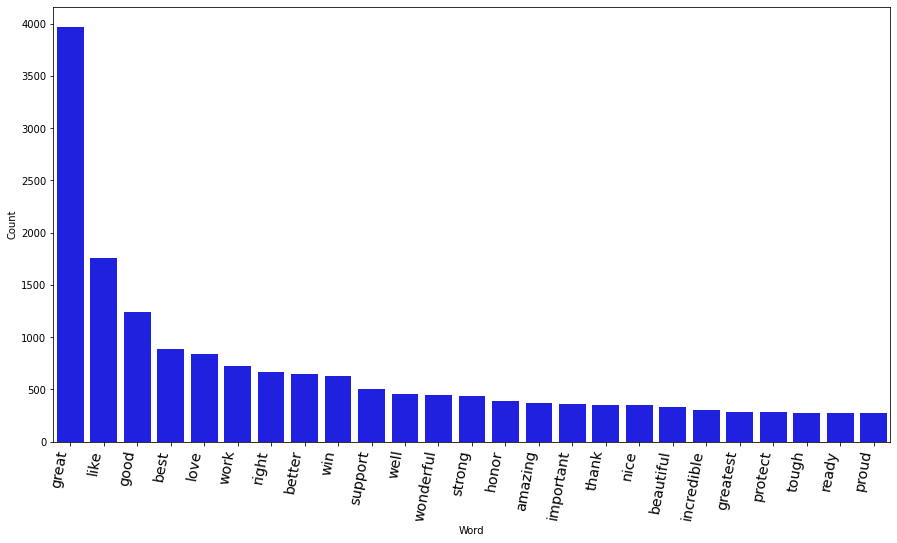

In [54]:
plot_contextual_words(list_top_positives_opinion)

### c) Top Negatives

In [14]:
negative_words = sc.textFile('drive/MyDrive/Spark_Project/DATA/negative-words.txt')

negative_words.take(5)

['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable']

In [15]:
# initialize an rdd with key/value for counting each negative word in the file 

negative_words_kv = negative_words.map(lambda word: (word, 1))

negative_words_kv.take(5)

[('2-faced', 1),
 ('2-faces', 1),
 ('abnormal', 1),
 ('abolish', 1),
 ('abominable', 1)]

In [16]:
# rdd_negative_words_tweet_kv RDD should contain negative words in the tweet review file

negative_words_tweets_kv = tweets_words_kv.join(negative_words_kv)

negative_words_tweets_kv.take(5)

[('threat', (1, 1)),
 ('threat', (1, 1)),
 ('threat', (1, 1)),
 ('threat', (1, 1)),
 ('threat', (1, 1))]

In [17]:
# use the mapValues transformation to assign a default count of 1 for each negative word

negative_words_tweets_kv = negative_words_tweets_kv.mapValues(lambda tuple:1)

negative_words_tweets_kv.take(5)

[('threat', 1), ('threat', 1), ('threat', 1), ('threat', 1), ('threat', 1)]

In [18]:
# rdd_negative_words_tweets_count_kv should contain the number of occurences (count) of each negative word in tweet reviews

negative_words_tweets_count_kv = negative_words_tweets_kv.reduceByKey(lambda x,y: x+y)

negative_words_tweets_count_kv.take(5)

[('threat', 68),
 ('dishonest', 148),
 ('lost', 306),
 ('killed', 154),
 ('risk', 57)]

In [19]:
# rdd_negative_words_tweet_count_kv_ordered should contain the previous RDD in descending order based on the count

negative_words_tweets_count_kv_ordered = negative_words_tweets_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)

list_top_negatives_opinion = negative_words_tweets_count_kv_ordered.take(25)

list_top_negatives_opinion

[('bad', 718),
 ('hard', 616),
 ('lost', 306),
 ('illegal', 300),
 ('terrible', 276),
 ('attack', 240),
 ('crime', 238),
 ('failed', 222),
 ('worst', 217),
 ('wrong', 213),
 ('corrupt', 203),
 ('phony', 191),
 ('badly', 188),
 ('weak', 179),
 ('failing', 168),
 ('problem', 167),
 ('hate', 164),
 ('destroy', 160),
 ('killed', 154),
 ('dishonest', 148),
 ('killing', 146),
 ('horrible', 145),
 ('disaster', 141),
 ('false', 139),
 ('debt', 138)]

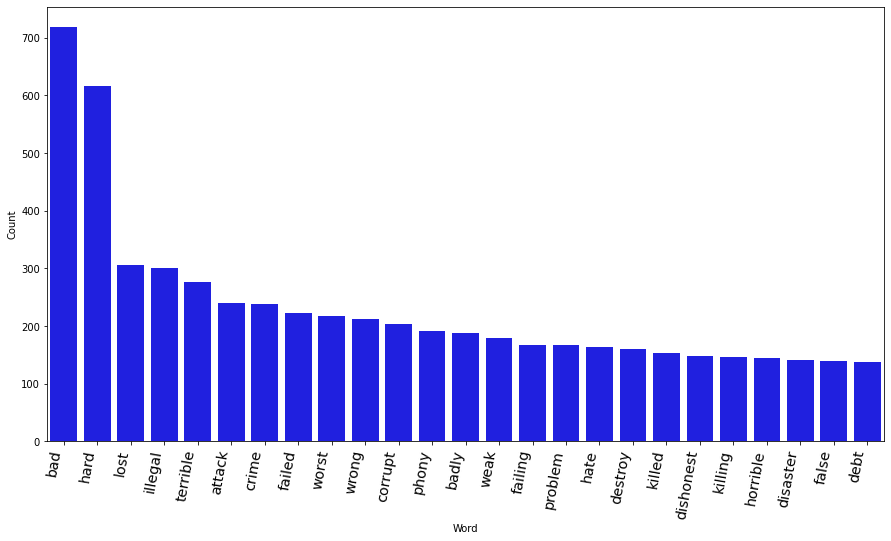

In [53]:
plot_contextual_words(list_top_negatives_opinion)

### Plot on those results 

#### Positive

#### Negative 

#### ALL 
This allow us to have an idea of the general sentiment.

We can see that negative words are superior in number than positives one. We could say that Trump is a negative guy / is using negative words more than positiveS

Let's see next how we can confirm that.

## Compute the global sentiment score

In [22]:
# Compute the global sentiment score: the total count of positive words (e.g. use rdd_positive_words_tweet_count_kv) minus
# the total count of negative words (e.g. use rdd_negative_words_tweet_count_kv)


sentiment_score = positive_words_tweets_count_kv.map(lambda tuple: tuple[1]).sum()\
                  - negative_words_tweets_count_kv.map(lambda tuple: tuple[1]).sum()

print('The sentiment score is : ',sentiment_score)

The sentiment score is :  11016


#Second Analysis

### Contextual words


In [ ]:
# we read our stop words

stop_words = sc.textFile('drive/MyDrive/Spark_Project/DATA/stop-words.txt')

stop_words.take(100)

In [24]:
#lowercase the RDD
def Func(lines):
      lines = lines.lower()
      return lines
tweets1 = tweets_words.map(Func)

In [25]:
tweets1.take(2)

['republicans', 'and']

In [ ]:
# compute the neutral/contextual words RDD by using rdd_tweet_words, rdd_positive_words, rdd_negative_words and rdd_stop_words
# neutral words are words in tweet reviews file, that are not positive words or negative words or stop words
# tip: you can use the subtract transformation on RDD see documentation 
# http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD

contextual_words = tweets1.subtract(stop_words).subtract(positive_words).subtract(negative_words)

contextual_words.take(10)

In [ ]:
contextual_words

In [28]:
# use multiple transformations for counting each contextual word in the tweet review file, sorted in ascending order based 
# on the count

contextual_words_count_ordered = contextual_words.map(lambda word: (word, 1))\
                                                 .reduceByKey(lambda x,y : x+y)\
                                                 .sortBy(lambda tuple: tuple[1], ascending=False)


list_top_contextual_words = contextual_words_count_ordered.take(50)  

list_top_contextual_words

[('@realdonaldtrump', 8809),
 ('rt', 7902),
 ('&amp', 5437),
 ('president', 3563),
 ('just', 3238),
 ('people', 2833),
 ('new', 2419),
 ('big', 1853),
 ('make', 1797),
 ('america', 1734),
 ('"rt', 1579),
 ('democrats', 1546),
 ('time', 1529),
 ('country', 1524),
 ('obama', 1457),
 ('going', 1453),
 ('donald', 1414),
 ('news', 1389),
 ('want', 1371),
 ('american', 1359),
 ('vote', 1321),
 ('need', 1165),
 ('u.s.', 1133),
 ('today', 1116),
 ('@realdonaldtrump:', 1089),
 ('think', 1073),
 ('really', 1067),
 ('run', 1058),
 ('doing', 1047),
 ('did', 1017),
 ('know', 986),
 ('media', 972),
 ('said', 947),
 ('job', 940),
 ('china', 925),
 ('years', 914),
 ('thanks', 887),
 ('way', 879),
 ("don't", 868),
 ('united', 854),
 ('house', 849),
 ('biden', 830),
 ('got', 825),
 ('state', 820),
 ('total', 807),
 ('day', 805),
 ('jobs', 805),
 ('hillary', 796),
 ('look', 784),
 ('states', 782)]

In [29]:
import pandas as pd

In [30]:
import matplotlib.pyplot as plt

In [31]:
import seaborn as sb

In [32]:
# the utility function plot_contextual_words plots a bar chart presenting top contextual words
# the parameter are list of tuples containing counts from contextual words

def plot_contextual_words(list_contextual_words):
    
    pd_df = pd.DataFrame({
        'Word':  [ t[0] for t in list_contextual_words ],
        'Count': [ t[1] for t in list_contextual_words ]
    }).sort_values('Count', ascending=False)
    
    plt.figure( figsize = (15, 8) )
    
    chart=sb.barplot(data=pd_df, x='Word', y='Count', order=pd_df['Word'], color='blue')
    
    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=80, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large',
        )
    
    plt.show()

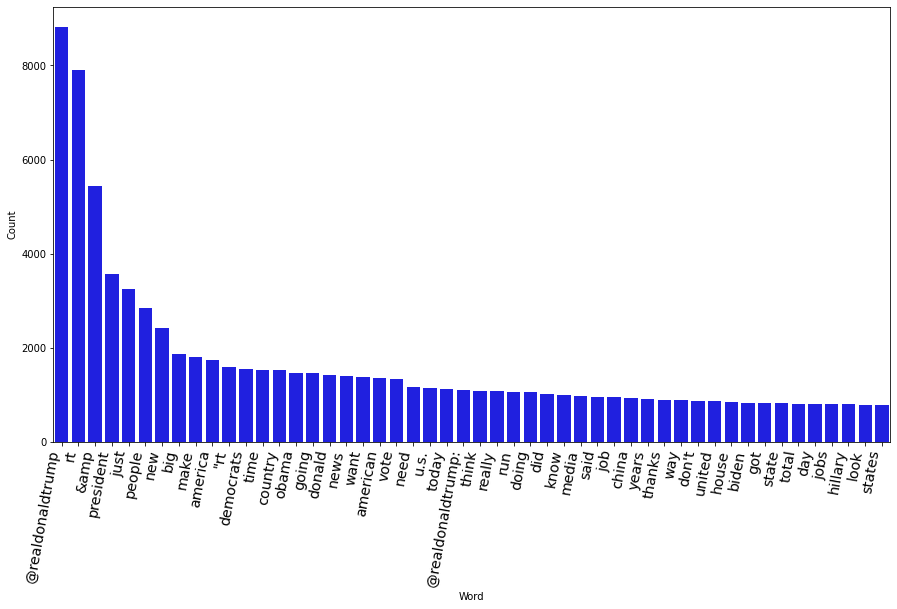

In [33]:
# call the plot_contextual_words function to plot our tweet reviews top contextual words

plot_contextual_words(list_top_contextual_words)

## Top hastags cited 


In [34]:
#need first to re split the original data to keep the "#"

def split_with_multiple_separator_new(string_value):
    return re.split(',| |\[|\]', string_value.strip())

# usage example:

split_with_multiple_separator_new(tweets.take(1)[0])

['Republicans',
 'and',
 'Democrats',
 'have',
 'both',
 'created',
 'our',
 'economic',
 'problems.;02/08/2011',
 '18:07:48']

In [35]:
tweets_words_new = tweets.flatMap(split_with_multiple_separator_new).filter(lambda word: word!='')

tweets_words_new.take(5)

['Republicans', 'and', 'Democrats', 'have', 'both']

In [36]:
filtered_hastags = tweets_words_new.filter(lambda x: x.startswith('#'))

In [37]:
filtered_hastags.take(20)

['#KAG2020',
 '#MAGA',
 '#VOTE',
 '#MAGA🇺🇸🦅rally',
 '#VOTE',
 '#2A',
 '#VOTE',
 '#MAGA',
 '#MAGA🇺🇸',
 '#MAGA',
 '#MAGA',
 '#Florida:',
 '#ProAmericaRally',
 '#AmyConeyBarrett',
 '#EarlyVoting',
 '#VOTE',
 '#Election2020',
 '#EarlyVoting',
 '#VoteEarly',
 '#…;16/10/2020']

In [38]:
contextual_h_count_ordered = filtered_hastags.map(lambda word: (word, 1))\
                                                 .reduceByKey(lambda x,y : x+y)\
                                                 .sortBy(lambda tuple: tuple[1], ascending=False)


list_top_hastags = contextual_h_count_ordered.take(50)  

list_top_hastags

[('#Trump2016', 395),
 ('#MAGA', 340),
 ('#MakeAmericaGreatAgain', 260),
 ('#1', 111),
 ('#CelebApprentice', 97),
 ('#CelebrityApprentice', 85),
 ('#KAG2020', 61),
 ('#AmericaFirst', 61),
 ('#Trump2016""""', 59),
 ('#Trump', 58),
 ('#VoteTrump', 54),
 ('#DrainTheSwamp', 50),
 ('#COVID19', 45),
 ('#TimeToGetTough', 38),
 ('#ImWithYou', 38),
 ('#BigLeagueTruth', 33),
 ('#USMCA', 32),
 ('#2A', 32),
 ('#TBT', 31),
 ('#FITN', 30),
 ('#CrookedHillary', 29),
 ('#MakeAmericaGreatAgain!', 29),
 ('#MAGA🇺🇸', 26),
 ('#trumpvlog', 23),
 ('#coronavirus', 22),
 ('#DemDebate', 22),
 ('#TrumpTrain', 22),
 ('#TRUMP', 21),
 ('#USA🇺🇸', 21),
 ('#PaycheckProtectionProgram', 21),
 ('#Debate', 20),
 ('#TrumpPence16', 20),
 ('#TrumpVlog', 20),
 ('#GOPDebate', 20),
 ('#USA', 19),
 ('#GOP', 19),
 ('#Dorian', 19),
 ('#MAGA!', 18),
 ('#COVID19.', 18),
 ('#IACaucus', 18),
 ('#FakeNews', 18),
 ('#CelebApprentice;15/04/2013', 18),
 ('#Debates2016', 18),
 ('#LESM', 18),
 ('#CelebApprentice""""""";05/01/2015', 18),
 ('

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0, flags=flags)


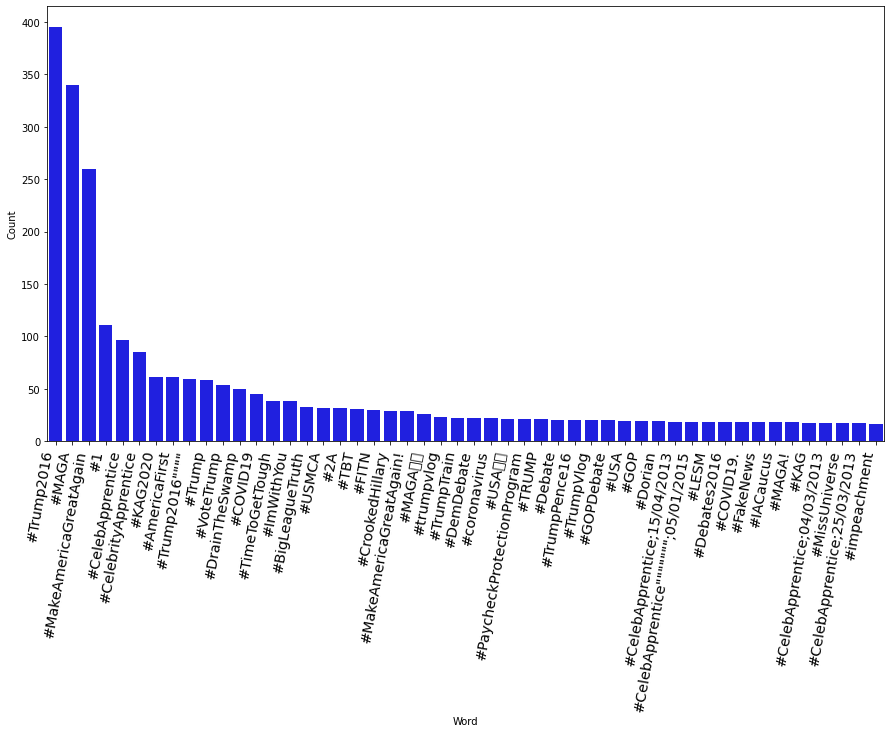

In [39]:
plot_contextual_words(list_top_hastags)

## Top references cited


In [40]:
filtered_references = tweets_words.filter(lambda x: x.startswith('@'))

In [41]:
contextual_r_count_ordered = filtered_references.map(lambda word: (word, 1))\
                                                 .reduceByKey(lambda x,y : x+y)\
                                                 .sortBy(lambda tuple: tuple[1], ascending=False)


list_top_references = contextual_r_count_ordered.take(50)  

list_top_references

[('@realDonaldTrump', 8641),
 ('@realDonaldTrump:', 1087),
 ('@WhiteHouse:', 658),
 ('@FoxNews', 537),
 ('@BarackObama', 492),
 ('@foxandfriends', 453),
 ('@CNN', 305),
 ('@ApprenticeNBC', 305),
 ('@TeamTrump:', 276),
 ('@GOPChairwoman:', 212),
 ('@MittRomney', 197),
 ('@nytimes', 179),
 ('@seanhannity', 174),
 ('@DanScavino:', 160),
 ('@IvankaTrump', 155),
 ('@Jim_Jordan:', 139),
 ('@GOP:', 138),
 ('@megynkelly', 134),
 ('@realDonaldTrump.', 134),
 ('@POTUS', 118),
 ("@BarackObama's", 117),
 ('@DonaldJTrumpJr:', 115),
 ('@Scavino45:', 114),
 ('@GreggJarrett:', 111),
 ('@oreillyfactor', 109),
 ('@IvankaTrump:', 107),
 ('@WhiteHouse', 105),
 ('@realdonaldtrump', 103),
 ('@Macys', 103),
 ('@realDonaldTrump""""', 98),
 ('@TomFitton:', 98),
 ("@realDonaldTrump's", 96),
 ('@EricTrump:', 96),
 ('@paulsperry_:', 92),
 ('@CelebApprentice', 86),
 ('@FLOTUS', 84),
 ('@FoxNews.', 84),
 ('@TrumpDoral', 84),
 ('@GOP', 83),
 ('@RepMarkMeadows:', 80),
 ('@DonaldJTrumpJr', 79),
 ('@marklevinshow:', 78

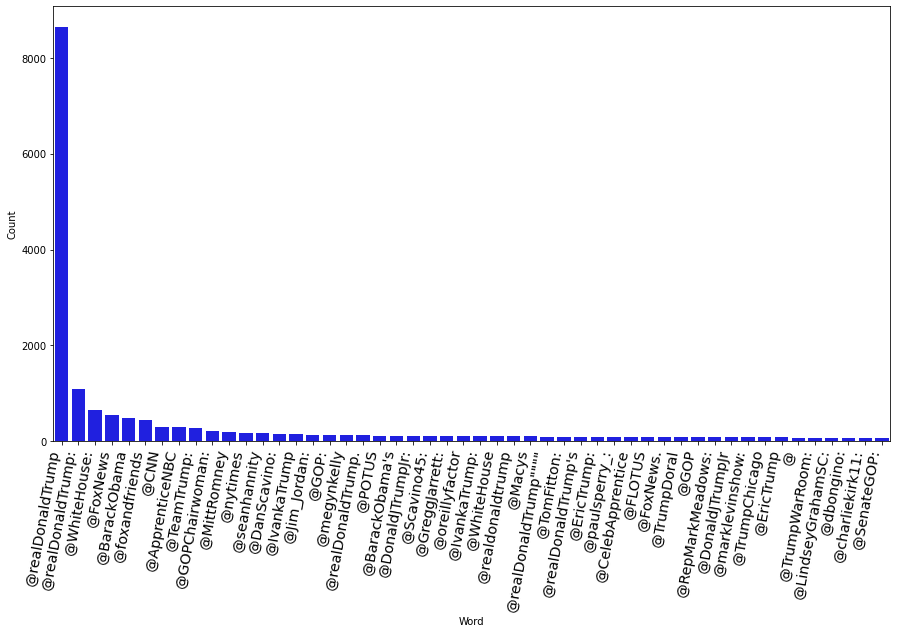

In [42]:
plot_contextual_words(list_top_references)

**Part 2: Real Estate Market Data Exploration in Toulouse and its suburbs**

The objective is to perform real estate data exploration near the city of Toulouse.
Your company (Immo-Inv) is a real estate agency who wants to understand very
well the real estate market in Toulouse and its suburbs. You are the big data
analyst of the company and you have access to a 5-years real data history of
houses and apartments sales transactions in Toulouse and its suburbs. The
dataset contains details for each transaction: sale date, localization (city, postal
code), type of residence, type of sale, land area, living area, number of rooms,
price, etc.).

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg,date_format, isnull, when, ceil
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, cast
from pyspark.sql.functions import to_date
from pyspark.sql.functions import date_format
from pyspark.sql.types import DateType

# start a spark session
spark = SparkSession.builder.appName("RealEstateAnalysis").getOrCreate()

# read the dataset into a DataFrame
df = spark.read.csv(r"C:\Users\Riviere\OneDrive\Bureau\Spark\project_data_real_estate_toulouse_and_suburbs.csv", header=True, inferSchema=True, dateFormat='dd/MM/YYYY')
df.show()
df.head(5)

df.printSchema()

+--------------------------------------------------------------------------------------+
|SaleDate;SaleType;Price;PostCode;City;NbRooms;NbLots;ResidenceType;LivingArea;LandArea|
+--------------------------------------------------------------------------------------+
|                                                                  15/01/2019;SALE;9...|
|                                                                  21/01/2019;SALE;2...|
|                                                                  03/01/2019;SALE;1...|
|                                                                  11/01/2019;SALE;5...|
|                                                                  15/01/2019;SALE;1...|
|                                                                  15/01/2019;SALE;2...|
|                                                                  18/01/2019;SALE;2...|
|                                                                  16/01/2019;SALE B...|
|                    

**Step 1 : Data Transforming**

The first part is to delimitate correctly the table, and transforming our data type.

In [2]:

from pyspark.sql.types import *

sales_schema =StructType ( [StructField("SaleDate", DateType(), True),
                           StructField("SaleType", StringType(), True),
                           StructField("Price", DoubleType(), True),
                           StructField("PostCode", IntegerType(), True),
                           StructField("City", StringType(), True),
                           StructField("NbRooms", DoubleType(), True),
                           StructField("NbLots", DoubleType(), True),
                           StructField("ResidenceType", StringType(), True),
                           StructField("LivingArea", DoubleType(), True),
                           StructField("LandArea", DoubleType(), True),]
                        )
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")
df = spark.read.csv(r"C:\Users\Riviere\OneDrive\Bureau\Spark\project_data_real_estate_toulouse_and_suburbs.csv", header=True, sep=';', dateFormat='dd/MM/YYYY')
df = df.withColumn("SaleDate", to_date(col("SaleDate"), "dd/mm/YYYY"))
df = df.withColumn("sale_year", date_format(col("SaleDate"), "yyyy").cast("integer"))
df = df.withColumn("NbRooms",df["NbRooms"].cast("double"))
df = df.withColumn("City", col("City").cast("string"))
df = df.withColumn("ResidenceType", col("ResidenceType").cast("string"))
df.show(7)

+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+---------+
|  SaleDate|SaleType| Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|sale_year|
+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+---------+
|2018-12-30|    SALE| 95000|   31270|VILLENEUVE TOLOSANE|    2.0|     0|        HOUSE|        45|     505|     2018|
|2018-12-30|    SALE|261700|   31270|VILLENEUVE TOLOSANE|    4.0|     0|        HOUSE|        87|     311|     2018|
|2018-12-30|    SALE|101000|   31270|VILLENEUVE TOLOSANE|    2.0|     1|    APARTMENT|        44|       0|     2018|
|2018-12-30|    SALE| 59500|   31270|VILLENEUVE TOLOSANE|    1.0|     1|    APARTMENT|        26|       0|     2018|
|2018-12-30|    SALE|179000|   31270|VILLENEUVE TOLOSANE|    4.0|     0|        HOUSE|        95|     263|     2018|
|2018-12-30|    SALE|209300|   31270|VILLENEUVE TOLOSANE|    4.0

In the same process we add a new coloumn : 'Sale_year' obtained by the function : 'dateformat'.

In case of na value we add 0 for missing values

In [3]:
df = df.na.fill(0)

**Step 2 : Calculation**

We transformed our data type. Now we can add relevent coloumn to study more precisely our data. Here we are looking for the price m².
we took care to round the unit with the function "ceil"

In [4]:
df = df.withColumn("price_per_sqm", ceil(df["Price"]/(df["LivingArea"]+df["LandArea"])))
df.show(7)

+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+---------+-------------+
|  SaleDate|SaleType| Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|sale_year|price_per_sqm|
+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+---------+-------------+
|2018-12-30|    SALE| 95000|   31270|VILLENEUVE TOLOSANE|    2.0|     0|        HOUSE|        45|     505|     2018|          173|
|2018-12-30|    SALE|261700|   31270|VILLENEUVE TOLOSANE|    4.0|     0|        HOUSE|        87|     311|     2018|          658|
|2018-12-30|    SALE|101000|   31270|VILLENEUVE TOLOSANE|    2.0|     1|    APARTMENT|        44|       0|     2018|         2296|
|2018-12-30|    SALE| 59500|   31270|VILLENEUVE TOLOSANE|    1.0|     1|    APARTMENT|        26|       0|     2018|         2289|
|2018-12-30|    SALE|179000|   31270|VILLENEUVE TOLOSANE|    4.0|     0|        HOU

**1 st KeyFiding**

This new coloumn can  illustrate us the average price m² by year. It shows an deacrese since 2014.

In [6]:
df.withColumn("sale_year",date_format(df["SaleDate"], "yyyy")).groupBy("sale_year").agg(avg("price_per_sqm").alias("avg_price_sqm")).sort("sale_year", ascending=True).show()

+---------+------------------+
|sale_year|     avg_price_sqm|
+---------+------------------+
|     2014| 8178.832030581389|
|     2015| 5186.102521679599|
|     2017| 4502.104989833489|
|     2018|4067.8295615275815|
+---------+------------------+



The first assumption with this information is to better understand the potential outlier. Then, the differences in prices across different cities

In [7]:
df.describe().show()
df.groupBy('City').agg(avg('price_per_sqm').alias('avg_price_sqm')).sort('avg_price_sqm', ascending = False).show()

+-------+--------------------+------------------+------------------+-------------------+------------------+------------------+-------------+-----------------+------------------+-----------------+------------------+
|summary|            SaleType|             Price|          PostCode|               City|           NbRooms|            NbLots|ResidenceType|       LivingArea|          LandArea|        sale_year|     price_per_sqm|
+-------+--------------------+------------------+------------------+-------------------+------------------+------------------+-------------+-----------------+------------------+-----------------+------------------+
|  count|               80118|             80118|             80118|              80118|             80118|             80118|        80118|            80118|             80118|            80118|             77105|
|   mean|                null| 552147.5415342714|31330.177238573106|               null| 3.000099852717242|1.0370453580968073|         null|

Here, we can see that : 'AUCAMVILLE' got the hight price by m² : 7388.45€ and then TOULOUSE with 6902.61€

In [13]:
df.groupBy('City','sale_year').agg(avg('price_per_sqm').alias('avg_price_sqm')).sort('sale_year', ascending = False).show()

+--------------------+---------+------------------+
|                City|sale_year|     avg_price_sqm|
+--------------------+---------+------------------+
|           COLOMIERS|     2018| 1714.092485549133|
|               MURET|     2018|1319.7692307692307|
|              PIBRAC|     2018| 767.9655172413793|
|  PLAISANCE DU TOUCH|     2018| 897.7755102040817|
|   QUINT-FONSEGRIVES|     2018|            1427.0|
|RAMONVILLE-SAINT-...|     2018| 2194.695652173913|
|        CORNEBARRIEU|     2018|1765.3725490196077|
| VILLENEUVE TOLOSANE|     2018|             756.0|
|          SAINT-JEAN|     2018| 1477.018018018018|
|             L UNION|     2018| 755.9545454545455|
|  PORTET SUR GARONNE|     2018| 915.3666666666667|
|              LABEGE|     2018|             372.5|
|SAINT-ORENS-DE-GA...|     2018|1067.6315789473683|
|             CUGNAUX|     2018|1810.3255813953488|
|    VIEILLE TOULOUSE|     2018|             311.0|
|       TOURNEFEUILLE|     2018|1364.7766990291261|
|          F

We want to see which city has the higher sales record

In [22]:
from pyspark.sql.types import *
df.groupBy('City').count().sort('count', ascending = False).show()

+--------------------+-----+
|                City|count|
+--------------------+-----+
|            TOULOUSE|51797|
|             BLAGNAC| 5174|
|           COLOMIERS| 2785|
|       TOURNEFEUILLE| 2510|
|             CUGNAUX| 1921|
|               BALMA| 1408|
|               MURET| 1364|
|RAMONVILLE-SAINT-...| 1323|
|    CASTANET TOLOSAN| 1317|
|SAINT-ORENS-DE-GA...| 1147|
|          SAINT-JEAN| 1135|
|  PLAISANCE DU TOUCH|  999|
|          AUCAMVILLE|  977|
|             L UNION|  959|
|            LEGUEVIN|  675|
|        CORNEBARRIEU|  647|
| VILLENEUVE TOLOSANE|  633|
|           BEAUZELLE|  597|
|  PORTET SUR GARONNE|  569|
|              PIBRAC|  550|
+--------------------+-----+
only showing top 20 rows



It's not a suprise, Toulouse has the highest count. However, VILLENEUVE TOLOSANE has the best price m², but in the meantime, the city has one of the lowest sales record, then we can imagine that there is some outliers in VILLENEUVE TOLOSANE that compromise the price by m².

Let's head back in the to price by m² by year to illustrate it with graph 

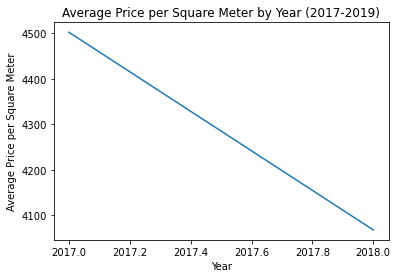

In [24]:
from matplotlib import pyplot as plt
import pandas as pd
from pyspark.sql.functions import year

# Use the 'groupBy' and 'agg' functions to calculate the average price per square meter for each year
df_2017_2019 = df.filter(df['sale_year'] >= 2017).filter(df['sale_year'] <= 2019).groupBy('sale_year').agg(avg('price_per_sqm').alias('avg_price_sqm'))

# Convert the DataFrame to a pandas DataFrame
df_2017_2019_pd = df_2017_2019.toPandas()

# Create the line graph
plt.plot(df_2017_2019_pd['sale_year'], df_2017_2019_pd['avg_price_sqm'])
plt.xlabel('Year')
plt.ylabel('Average Price per Square Meter')
plt.title('Average Price per Square Meter by Year (2017-2019)')
plt.show()

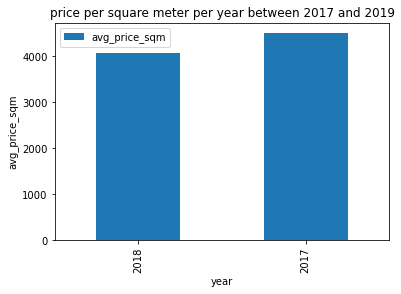

In [26]:
df_filtered = df.filter((year(df["SaleDate"]) >= 2017) & (year(df["SaleDate"]) <= 2019))
df_agg = df_filtered.groupBy(year(df["SaleDate"]).alias("year")).agg(avg("price_per_sqm").alias("avg_price_sqm"))
df_agg_pd = df_agg.toPandas()

df_agg_pd.plot.bar(x='year', y='avg_price_sqm')
plt.xlabel('year')
plt.ylabel('avg_price_sqm')
plt.title('price per square meter per year between 2017 and 2019')
plt.show()

Important deacrese by comparing 2017 and 2018

Last Keyfinding, lets compare price of appartment and house :

In [33]:
# Differences between apartments and houses
apartment_df = df.filter(df['ResidenceType'] == 'APARTMENT').sort('price_per_sqm', ascending = False).show(5)

+----------+--------+--------+--------+--------+-------+------+-------------+----------+--------+---------+-------------+
|  SaleDate|SaleType|   Price|PostCode|    City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|sale_year|price_per_sqm|
+----------+--------+--------+--------+--------+-------+------+-------------+----------+--------+---------+-------------+
|2014-12-28|    SALE|33427218|   31400|TOULOUSE|    2.0|     1|    APARTMENT|        42|       0|     2014|       795887|
|2014-12-28|    SALE|33427218|   31400|TOULOUSE|    2.0|     1|    APARTMENT|        42|       0|     2014|       795887|
|2014-12-28|    SALE|33427218|   31400|TOULOUSE|    2.0|     1|    APARTMENT|        42|       0|     2014|       795887|
|2014-12-28|    SALE|33427218|   31200|TOULOUSE|    2.0|     1|    APARTMENT|        43|       0|     2014|       777378|
|2014-12-28|    SALE|33427218|   31400|TOULOUSE|    2.0|     1|    APARTMENT|        43|       0|     2014|       777378|
+----------+--------+---

In [34]:
houses_df = df.filter(df['ResidenceType'] == 'HOUSE').sort('price_per_sqm', ascending = False).show(5)

+----------+--------+-------+--------+--------+-------+------+-------------+----------+--------+---------+-------------+
|  SaleDate|SaleType|  Price|PostCode|    City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|sale_year|price_per_sqm|
+----------+--------+-------+--------+--------+-------+------+-------------+----------+--------+---------+-------------+
|2017-01-01|    SALE|3750000|   31200|TOULOUSE|    5.0|     0|        HOUSE|       113|       0|     2017|        33186|
|2015-12-27|    SALE|1991352|   31270| CUGNAUX|    3.0|     3|        HOUSE|        62|       0|     2015|        32119|
|2015-12-27|    SALE|1991352|   31270| CUGNAUX|    3.0|     3|        HOUSE|        62|       0|     2015|        32119|
|2015-12-27|    SALE|1991352|   31270| CUGNAUX|    3.0|     3|        HOUSE|        62|       0|     2015|        32119|
|2015-12-27|    SALE|1991352|   31270| CUGNAUX|    3.0|     3|        HOUSE|        62|       0|     2015|        32119|
+----------+--------+-------+---

Best year for appartment was in 2014 at Toulouse, regarding the housing market it is at Gunaux mainly in 2015

Let's finish by machine learning by using a Linear Regression 

In [ ]:
assembler = VectorAssembler(inputCols=['sale_year', 'City', 'ResidenceType', 'NbRooms'], outputCol='features')
data = assembler.transform(df)
(trainingData, testData) = data.randomSplit([0.7, 0.3])
# Select the features for the model
assembler = VectorAssembler(inputCols=['sale_year', 'City', 'ResidenceType', 'NbRooms'], outputCol='features')
data = assembler.transform(df)

# Split the data into training and test sets
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train the model
lr = LinearRegression(labelCol='price_per_sqm')
lrModel = lr.fit(trainingData)

# Make predictions on the test set
predictions = lrModel.transform(testData)

# Evaluate the model using appropriate metrics
evaluator = RegressionEvaluator(label = 'price_per_sqm', predictionCol='prediction', metricName='r2')
r2 = evaluator.evaluate(predictions)
print("R-squared value: ", r2)

# Extract the model's coefficients
coefficients = lrModel.coefficients
print("Coefficients: ", coefficients)

# Extract the model's intercept
intercept = lrModel.intercept
print("Intercept: ", intercept)